In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
x_cols = ['Loan_age', 'CreditScore',
       'FullDocumentation', 'State_CA', 'State_FL', 'State_NY', 'State_NJ',
       'State_GA', 'Spread', 'Spread_squared', 'Remaining_balance', 'LTV',
       'spring_summer']
indicator_cols = ['Default_indicator', 'Prepayment_indicator']
y_cols = ['status']

In [3]:
loans_df = pd.read_csv('notebooks/FRM_perf.csv')
is_active = loans_df[['Default_indicator', 'Prepayment_indicator']].sum(axis=1) == 0
loans_df['status'] = loans_df[indicator_cols].assign(Active=is_active.astype(int)).idxmax(axis=1).str.replace('_indicator', '').astype('category')
categories = loans_df['status'].cat.categories

train_loan_id, test_loan_id = train_test_split(loans_df['Loan_id'].unique(), test_size=0.1, random_state=0)
train_loans = loans_df.loc[loans_df['Loan_id'].isin(train_loan_id)]
test_loans = loans_df.loc[loans_df['Loan_id'].isin(test_loan_id)]

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import ADASYN, RandomOverSampler


In [5]:
clf = RandomForestClassifier(max_depth=5)
X_resampled, y_resampled = RandomOverSampler().fit_resample(train_loans[x_cols], train_loans[y_cols])
clf.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=5)

In [6]:
calc_auc = lambda df: roc_auc_score(df[y_cols].squeeze(), clf.predict_proba(df[x_cols]), multi_class='ovr')
calc_auc(train_loans), calc_auc(test_loans)

(0.8855354094415792, 0.8230775992990668)

In [7]:
calc_avg_prob = lambda df: pd.DataFrame(clf.predict_proba(df[x_cols]), columns=categories).assign(status=df[y_cols].values).pivot_table(index='status')
calc_avg_prob(train_loans), calc_avg_prob(test_loans)

(              Active   Default  Prepayment
 status                                    
 Active      0.523011  0.392226    0.084762
 Default     0.392579  0.533664    0.073757
 Prepayment  0.084962  0.074041    0.840996,
               Active   Default  Prepayment
 status                                    
 Active      0.511388  0.406804    0.081808
 Default     0.416937  0.468998    0.114064
 Prepayment  0.086431  0.100047    0.813523)

<AxesSubplot:>

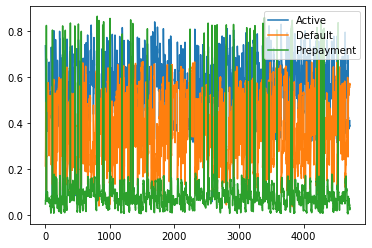

In [8]:
pd.DataFrame(clf.predict_proba(test_loans[x_cols]), columns=categories).plot()

In [9]:
y_resampled['status'].value_counts()

Active        43847
Default       43847
Prepayment    43847
Name: status, dtype: int64

In [10]:
train_loans[y_cols]['status'].value_counts()

Active        43847
Default         403
Prepayment      309
Name: status, dtype: int64

In [11]:
from importlib import import_module
distillnntree = import_module('distill-nn-tree.models')
distillnntreeutils = import_module('distill-nn-tree.models.utils')

ConvNet, SoftBinaryDecisionTree = distillnntree.ConvNet, distillnntree.SoftBinaryDecisionTree
brand_new_tfsession, draw_tree = distillnntreeutils.brand_new_tfsession, distillnntreeutils.draw_tree

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.callbacks import EarlyStopping, Callback

Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
n_features = len(x_cols)
n_classes = len(categories)
tree_depth = 4
penalty_strength = 1e+1
penalty_decay = 0.25
ema_win_size = 1000
inv_temp = 0.01
learning_rate = 5e-05
batch_size = 4

In [13]:
sess = brand_new_tfsession()

In [14]:
X_resampled
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_resampled)
pd.DataFrame(scaler.transform(X_resampled))
X_resampled

,Loan_age,CreditScore,FullDocumentation,State_CA,State_FL,State_NY,State_NJ,State_GA,Spread,Spread_squared,Remaining_balance,LTV,spring_summer
0,1,578,1,0,0,0,0,0,4.296500,18.459912,0.997678,0.900000,0
1,2,578,1,0,0,0,0,0,4.225000,17.850625,0.997087,0.888731,0
2,3,578,1,0,0,0,0,0,4.292857,18.428622,0.996492,0.879675,0
3,4,578,1,0,0,0,0,0,4.344000,18.870336,0.995892,0.872705,0
4,5,578,1,0,0,0,0,0,4.191053,17.564922,0.995288,0.867726,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131536,13,644,1,0,0,0,1,0,4.835909,23.386017,0.000000,0.905000,0
131537,7,585,1,0,0,0,0,0,6.140000,37.699600,0.000000,0.920577,0
131538,17,594,0,0,0,0,0,0,4.679286,21.895715,0.000000,0.804640,1
131539,25,673,1,0,0,0,0,0,4.400476,19.364191,0.000000,0.835709,1


In [15]:
sess = brand_new_tfsession(sess)

hardtree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
hardtree.build_model()


epochs = 10

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
# os.remove('assets/non-distilled/checkpoint')
# for f in glob.glob('assets/non-distilled/tree-model*'):
#     os.remove(f)

# soft tree learning hard labels
hardtree.maybe_train(
    sess=sess, data_train=(scaler.transform(X_resampled), y_resampled['status'].map(dict(zip(categories, range(3))))),
    data_valid=(scaler.transform(test_loans[x_cols]), test_loans[y_cols]['status'].map(dict(zip(categories, range(3))))),
    batch_size=batch_size, epochs=epochs, callbacks=[es])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [32]:
roc_auc_score(y_resampled['status'].map(dict(zip(categories, range(3)))), hardtree.predict(scaler.transform(X_resampled)), multi_class='ovr')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Built tree has 16 leaves out of 31 nodes
Loading trained model from assets/non-distilled/tree-model.
INFO:tensorflow:Restoring parameters from assets/non-distilled/tree-model


0.5041827128353081

In [20]:
n_features = len(x_cols)
n_classes = len(categories)
tree_depth = 4
penalty_strength = 1e+1
penalty_decay = 0.25
ema_win_size = 1000
inv_temp = 0.01
learning_rate = 5e-03
batch_size = 4

In [21]:
sess = brand_new_tfsession(sess)

softtree = SoftBinaryDecisionTree(tree_depth, n_features, n_classes,
    penalty_strength=penalty_strength, penalty_decay=penalty_decay,
    inv_temp=inv_temp, ema_win_size=ema_win_size, learning_rate=learning_rate)
softtree.build_model()



epochs = 10

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1)

'''If you wish to train your own model instead of loading one from checkpoint, remove the checkpoint.'''
# os.remove('assets/non-distilled/checkpoint')
# for f in glob.glob('assets/non-distilled/tree-model*'):
#     os.remove(f)

# soft tree learning soft labels
# clf.predict_proba(X_resampled)
softtree.maybe_train(
    sess=sess, data_train=(scaler.transform(X_resampled), clf.predict_proba(X_resampled)),
    data_valid=(scaler.transform(test_loans[x_cols]), test_loans[y_cols]['status'].map(dict(zip(categories, range(3))))),
    batch_size=batch_size, epochs=epochs, callbacks=[es], distill=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Built tree has 16 leaves out of 31 nodes
Loading trained model from assets/distilled/tree-model.
assets/distilled/tree-model is not a valid checkpoint. Training from scratch.
Train on 131541 samples, validate on 4717 samples
Epoch 1/10
131541/131541 [==============================] - 132s 1ms/sample - loss: inf - acc: 0.3864 - val_loss: -10.8913 - val_acc: 0.9970
Epoch 2/10
131541/131541 [========

In [33]:
roc_auc_score(y_resampled['status'].map(dict(zip(categories, range(3)))), softtree.predict(scaler.transform(X_resampled)), multi_class='ovr')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Built tree has 16 leaves out of 31 nodes
Loading trained model from assets/distilled/tree-model.
INFO:tensorflow:Restoring parameters from assets/distilled/tree-model


0.8230115684641851